In [ ]:
# --- FOR DATA AUGMENTATION ---

In [20]:
import os
import random
import yaml
from pathlib import Path
from collections import Counter, defaultdict

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [21]:
# ~~~~ Make augmentation dirs ~~~

# ~~~~~~~~~~ Config ~~~~~~~~~~
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

IMG_DIR = os.path.join("..", "images/train")
LABEL_DIR = os.path.join("..", "labels/train")

OUT_IMG = os.path.join(ROOT, "images", "train_augmented")
OUT_LBL = os.path.join(ROOT, "labels", "train_augmented")

YAML_PATH  = os.path.join(ROOT + "/config.yml")

with open(YAML_PATH) as f:
    cfg = yaml.safe_load(f)
names = cfg["names"]

MIN_BOX_AREA   = 0.001    # discard boxes smaller than 0.1% of image after transform

os.makedirs(OUT_IMG, exist_ok=True)
os.makedirs(OUT_LBL, exist_ok=True)
print("=== train_augmented files created ===")

=== train_augmented files created ===


In [ ]:
# Define folders for augmentation dataset     

# ~~~~~~~~~~~~~~~ Function to load labels ~~~~~~~~~~~~~~~~~~~~~~
def load_labels(label_path):
    labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                labels.append((class_id, x_center, y_center, width, height))
    return labels

# ~~~~~~~~~~~~ Save the labels into the output folder ~~~~~~~~~~~~
def save_labels(labels, out_path):
    with open(out_path, "w") as f:
        for b in labels:
            f.write(f"{b[0]} {b[1]:.6f} {b[2]:.6f} {b[3]:.6f} {b[4]:.6f}\n")

# ~~~~~~~~~~~~ Clipping ~~~~~~~~~~~~
def clip_labels(cx, cy, w, h):
    x1 = max(0.0, cx - w / 2)
    y1 = max(0.0, cy - h / 2)
    x2 = min(1.0, cx + w / 2)
    y2 = min(1.0, cy + h / 2)
    new_w = x2 - x1
    new_h = y2 - y1
    new_cx = x1 + new_w / 2
    new_cy = y1 + new_h / 2
    return new_cx, new_cy, new_w, new_h

# ~~~~~~~~~~~ Check if it is a valid box after transformation ~~~~~~~~~~~
def is_valid_box(cx, cy, w, h):
    return w > 0 and h > 0 and w * h >= MIN_BOX_AREA


def transform_boxes(boxes, crop_x1, crop_y1, crop_x2, crop_y2, orig_w, orig_h, min_vis=0.5):
    """
    Correctly transforms YOLO boxes after any crop operation.
    All augmentations should call this instead of doing their own math.
    
    Args:
        boxes:            list of [cls, cx, cy, bw, bh] in normalized coords
        crop_x1/y1/x2/y2: pixel coords of the crop region
        orig_w/h:         original image dimensions
        min_vis:          minimum visibility ratio to keep a box (0.0 to 1.0)
    """
    crop_w = crop_x2 - crop_x1
    crop_h = crop_y2 - crop_y1
    new_boxes = []

    for b in boxes:
        cls, cx, cy, bw, bh = b

        # Step 1: convert normalized -> pixel coords in ORIGINAL image
        px1 = (cx - bw/2) * orig_w
        py1 = (cy - bh/2) * orig_h
        px2 = (cx + bw/2) * orig_w
        py2 = (cy + bh/2) * orig_h

        # Step 2: intersect box with crop region
        ix1 = max(px1, crop_x1)
        iy1 = max(py1, crop_y1)
        ix2 = min(px2, crop_x2)
        iy2 = min(py2, crop_y2)

        # Step 3: skip if no intersection
        if ix2 <= ix1 or iy2 <= iy1:
            continue

        # Step 4: check visibility
        orig_area = (px2 - px1) * (py2 - py1)
        vis_area  = (ix2 - ix1) * (iy2 - iy1)
        if orig_area > 0 and vis_area / orig_area < min_vis:
            continue

        # Step 5: normalize relative to crop region (subtract offset first!)
        new_cx = ((ix1 + ix2) / 2 - crop_x1) / crop_w
        new_cy = ((iy1 + iy2) / 2 - crop_y1) / crop_h
        new_bw =  (ix2 - ix1) / crop_w
        new_bh =  (iy2 - iy1) / crop_h

        # Step 6: clamp to [0, 1]
        new_cx, new_cy, new_bw, new_bh = clip_labels(new_cx, new_cy, new_bw, new_bh)

        if is_valid_box(new_cx, new_cy, new_bw, new_bh):
            new_boxes.append([cls, new_cx, new_cy, new_bw, new_bh])

    return new_boxes



# ~~~~~~~~~~~ Augmentation #1: Cropping ~~~~~~~~~~~~
def random_crop(img, boxes, target_classes={1,3}, crop_ratio_range=(0.6, 0.9)):
    has_target = any(b[0] in target_classes for b in boxes)
    if not has_target:
        return None, None

    h, w = img.shape[:2]
    ratio  = random.uniform(*crop_ratio_range)
    crop_w = int(w * ratio)
    crop_h = int(h * ratio)
    x_off  = random.randint(0, w - crop_w)
    y_off  = random.randint(0, h - crop_h)

    cropped   = img[y_off:y_off+crop_h, x_off:x_off+crop_w]
    cropped   = cv2.resize(cropped, (w, h))
    new_boxes = transform_boxes(boxes, x_off, y_off, x_off+crop_w, y_off+crop_h, w, h, min_vis=0.5)

    return (cropped, new_boxes) if new_boxes else (None, None)


# ~~~~~~~~~~~ Augmentation #2: Horizontal Flip ~~~~~~~~~~~~
def horizontal_flip(img, boxes, target_classes={1,3}):
    has_target = any(b[0] in target_classes for b in boxes)
    if not has_target:
        return None, None

    h, w    = img.shape[:2]
    flipped = cv2.flip(img, 1)

    # Flip only mirrors cx — no crop so no need for transform_boxes
    new_boxes = [[cls, 1.0 - cx, cy, bw, bh] for cls, cx, cy, bw, bh in boxes]

    return flipped, new_boxes

# ~~~~~~~~~~~ Augmentation #3: Cropped Person ~~~~~~~~~~~~
def cropped_person(img, boxes):
    h, w = img.shape[:2]
    person_boxes = [b for b in boxes if b[0] == 0]
    if not person_boxes:
        return None, None

    target       = random.choice(person_boxes)
    cls, cx, cy, bw, bh = target
    py1 = int((cy - bh/2) * h)
    py2 = int((cy + bh/2) * h)
    person_h = py2 - py1

    if random.random() < 0.5:
        crop_y1 = 0
        crop_y2 = py1 + int(person_h * random.uniform(0.4, 0.6))  # top half
    else:
        crop_y1 = py1 + int(person_h * random.uniform(0.3, 0.5))  # bottom half
        crop_y2 = h

    crop_y1 = max(0, crop_y1)
    crop_y2 = min(h, crop_y2)

    if crop_y2 - crop_y1 < 50:
        return None, None

    cropped   = img[crop_y1:crop_y2, 0:w]
    cropped   = cv2.resize(cropped, (w, h))

    # person uses lower visibility threshold (20%), others use 50%
    new_boxes = []
    for b in boxes:
        min_vis   = 0.2 if b[0] == 0 else 0.5
        result    = transform_boxes([b], 0, crop_y1, w, crop_y2, w, h, min_vis=min_vis)
        new_boxes.extend(result)

    return (cropped, new_boxes) if new_boxes else (None, None)


# ~~~~~~~~~~~~~~~ Augmentation #4: Zoom In on Person ~~~~~~~~~~~~~~~
def zoom_person(img, boxes, zoom_range=(1.5, 2.0), min_crop_px=50):
    h, w = img.shape[:2]
    aspect = w / h

    person_boxes = [b for b in boxes if int(b[0]) == 0]
    if not person_boxes:
        return None, None

    cls, cx, cy, bw, bh = random.choice(person_boxes)

    px1 = (cx - bw / 2) * w;  px2 = (cx + bw / 2) * w
    py1 = (cy - bh / 2) * h;  py2 = (cy + bh / 2) * h
    person_h = py2 - py1

    if person_h <= 1:
        return None, None

    zoom_factor = random.uniform(*zoom_range)

    # Crop size — preserve aspect ratio
    crop_h = int(person_h * zoom_factor)
    crop_w = int(crop_h * aspect)

    if crop_h < min_crop_px or crop_w < min_crop_px:
        return None, None

    # Center crop on person
    center_x = cx * w
    center_y = cy * h
    crop_x1  = int(center_x - crop_w / 2)
    crop_y1  = int(center_y - crop_h / 2)
    crop_x2  = crop_x1 + crop_w
    crop_y2  = crop_y1 + crop_h

    # Shift to stay within bounds
    if crop_x1 < 0:
        crop_x2 -= crop_x1;  crop_x1 = 0
    if crop_y1 < 0:
        crop_y2 -= crop_y1;  crop_y1 = 0
    if crop_x2 > w:
        crop_x1 -= (crop_x2 - w);  crop_x2 = w
    if crop_y2 > h:
        crop_y1 -= (crop_y2 - h);  crop_y2 = h

    crop_x1 = max(0, crop_x1);  crop_y1 = max(0, crop_y1)
    crop_x2 = min(w, crop_x2);  crop_y2 = min(h, crop_y2)

    if (crop_x2 - crop_x1) < min_crop_px or (crop_y2 - crop_y1) < min_crop_px:
        return None, None

    cropped    = img[crop_y1:crop_y2, crop_x1:crop_x2]
    crop_h_eff = crop_y2 - crop_y1
    crop_w_eff = crop_x2 - crop_x1

    # ── Fix: resize preserving aspect ratio then pad ──
    scale       = min(w / crop_w_eff, h / crop_h_eff)
    new_w       = int(crop_w_eff * scale)
    new_h       = int(crop_h_eff * scale)
    resized     = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Pad to original size with grey (114 = YOLO standard background)
    zoomed      = np.full((h, w), 114, dtype=np.uint8) if len(img.shape) == 2 \
                  else np.full((h, w, img.shape[2]), 114, dtype=np.uint8)
    pad_y       = (h - new_h) // 2
    pad_x       = (w - new_w) // 2
    zoomed[pad_y:pad_y+new_h, pad_x:pad_x+new_w] = resized

    # ── Adjust boxes for padding offset ──
    # First transform boxes relative to crop region
    new_boxes = []
    for b in boxes:
        cls_b, cx_b, cy_b, bw_b, bh_b = b

        # Step 1: pixel coords in original image
        bpx1 = (cx_b - bw_b/2) * w;  bpx2 = (cx_b + bw_b/2) * w
        bpy1 = (cy_b - bh_b/2) * h;  bpy2 = (cy_b + bh_b/2) * h

        # Step 2: intersect with crop
        ix1 = max(bpx1, crop_x1);  ix2 = min(bpx2, crop_x2)
        iy1 = max(bpy1, crop_y1);  iy2 = min(bpy2, crop_y2)

        if ix2 <= ix1 or iy2 <= iy1:
            continue

        # Step 3: visibility check
        orig_area = (bpx2 - bpx1) * (bpy2 - bpy1)
        vis_area  = (ix2 - ix1)   * (iy2 - iy1)
        vis_ratio = vis_area / orig_area if orig_area > 0 else 0
        
        if cls_b == 0:
            min_vis = max(0.03, zoom_factor * 0.3)
        else:
            min_vis = 0.5

        if orig_area > 0 and vis_ratio < min_vis:
            continue

        # Step 4: coords relative to crop
        rel_x1 = ix1 - crop_x1;  rel_x2 = ix2 - crop_x1
        rel_y1 = iy1 - crop_y1;  rel_y2 = iy2 - crop_y1

        # Step 5: scale to resized dimensions
        scaled_x1 = rel_x1 * scale + pad_x
        scaled_y1 = rel_y1 * scale + pad_y
        scaled_x2 = rel_x2 * scale + pad_x
        scaled_y2 = rel_y2 * scale + pad_y

        # Step 6: normalize to output image size
        new_cx = ((scaled_x1 + scaled_x2) / 2) / w
        new_cy = ((scaled_y1 + scaled_y2) / 2) / h
        new_bw = (scaled_x2 - scaled_x1) / w
        new_bh = (scaled_y2 - scaled_y1) / h

        new_cx, new_cy, new_bw, new_bh = clip_labels(new_cx, new_cy, new_bw, new_bh)

        if is_valid_box(new_cx, new_cy, new_bw, new_bh):
            new_boxes.append([cls_b, new_cx, new_cy, new_bw, new_bh])

    return (zoomed, new_boxes) if new_boxes else (None, None)


augmentations = {'cropped': random_crop,
                 'flip': horizontal_flip,
                 'crop_person': cropped_person,
                 'zoom_person': zoom_person
                 }

# ~~~~~~~~~~~ Cap config — only person and car are limited ~~~~~~~~~~~~
MAX_AUGMENTED_PER_CLASS = {
    0: 500,   # person
    2: 20    # car
}

augmented_class_count = Counter()


# ~~~~~~~~~~~ Check if augmentation is still needed ~~~~~~~~~~~~
def under_cap(aug_labels, caps):
    """
    Returns True if:
    - At least one box belongs to a capped class that's still under cap, OR
    - At least one box belongs to an uncapped class (always allow)
    """
    for b in aug_labels:
        cls = b[0]
        if cls not in caps:
            return True   # uncapped class — always save
        if augmented_class_count[cls] < caps[cls]:
            return True   # capped class but still under limit
    return False


# ~~~~~~~~~~~ Filter boxes: remove capped classes that hit their limit ~~~~~~~~~~~~
def filter_capped_boxes(aug_labels, caps):
    """
    Removes boxes for classes that have hit their cap.
    Uncapped classes are always kept.
    """
    filtered = []
    for b in aug_labels:
        cls = b[0]
        if cls not in caps:
            filtered.append(b)   # uncapped — always keep
        elif augmented_class_count[cls] < caps[cls]:
            filtered.append(b)   # capped but still under limit
        # else: capped and at limit — drop this box
    return filtered


# ~~~~~~~~~~~ Main loop ~~~~~~~~~~~~
# img_paths = list(Path(IMG_DIR).glob("*.jpg"))

# for img_path in img_paths:
#     label_path = Path(LABEL_DIR) / (img_path.stem + ".txt")
#     if not label_path.exists():
#         continue

#     labels = load_labels(str(label_path))
#     if not labels:
#         continue

#     img = cv2.imread(str(img_path))
#     if img is None:
#         continue

#     for aug_name, aug_func in augmentations.items():
#         aug_img, aug_labels = aug_func(img.copy(), [list(b) for b in labels])

#         if aug_img is None or not aug_labels:
#             continue

#         # Check if there's any reason to save this augmented image
#         if not under_cap(aug_labels, MAX_AUGMENTED_PER_CLASS):
#             continue

#         # Remove boxes for classes that have hit their cap
#         aug_labels = filter_capped_boxes(aug_labels, MAX_AUGMENTED_PER_CLASS)

#         if not aug_labels:
#             continue

#         # Save
#         out_stem = f"{img_path.stem}_{aug_name}"
#         cv2.imwrite(str(Path(OUT_IMG) / f"{out_stem}.jpg"), aug_img)
#         save_labels(aug_labels, str(Path(OUT_LBL) / f"{out_stem}.txt"))

#         # Only update counts for capped classes
#         for b in aug_labels:
#             cls = b[0]
#             if cls in MAX_AUGMENTED_PER_CLASS:
#                 augmented_class_count[cls] += 1



Found 8205 images with person class


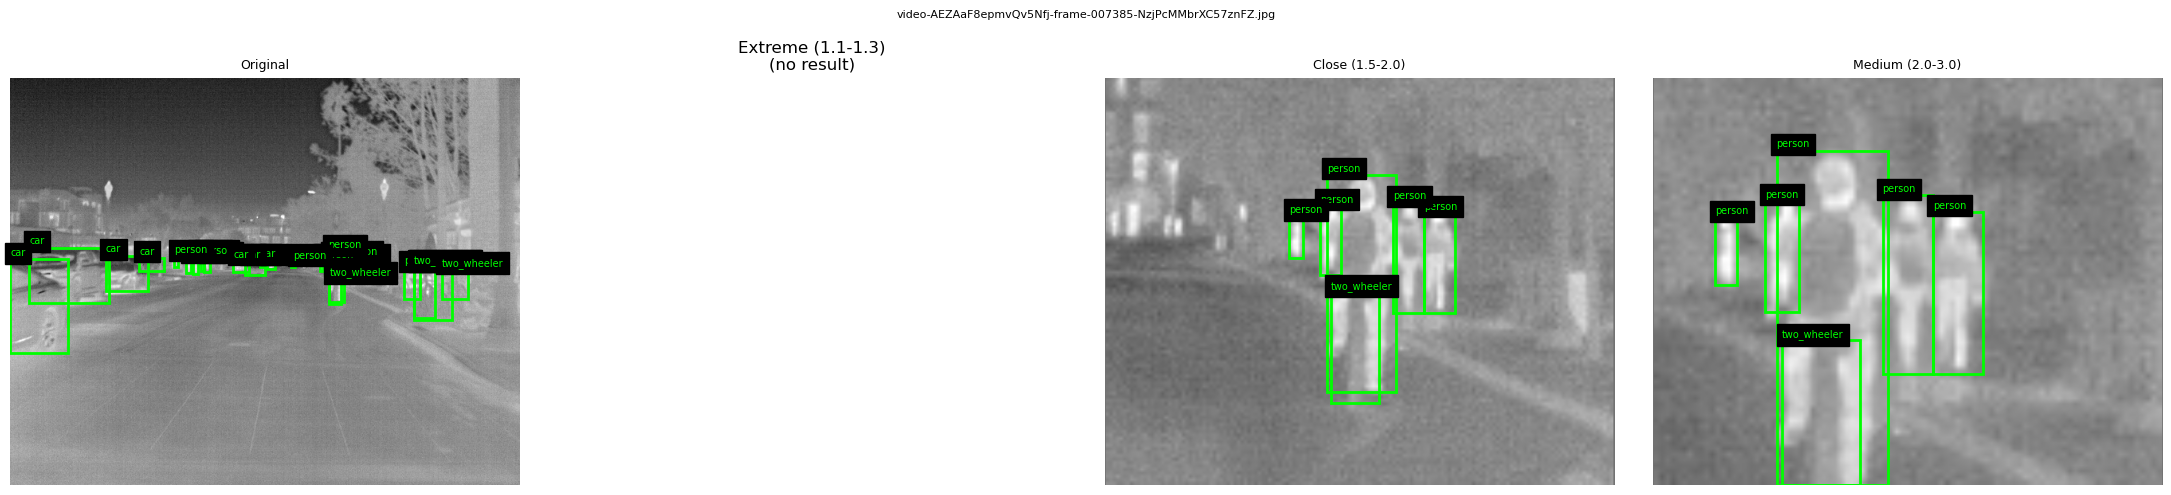

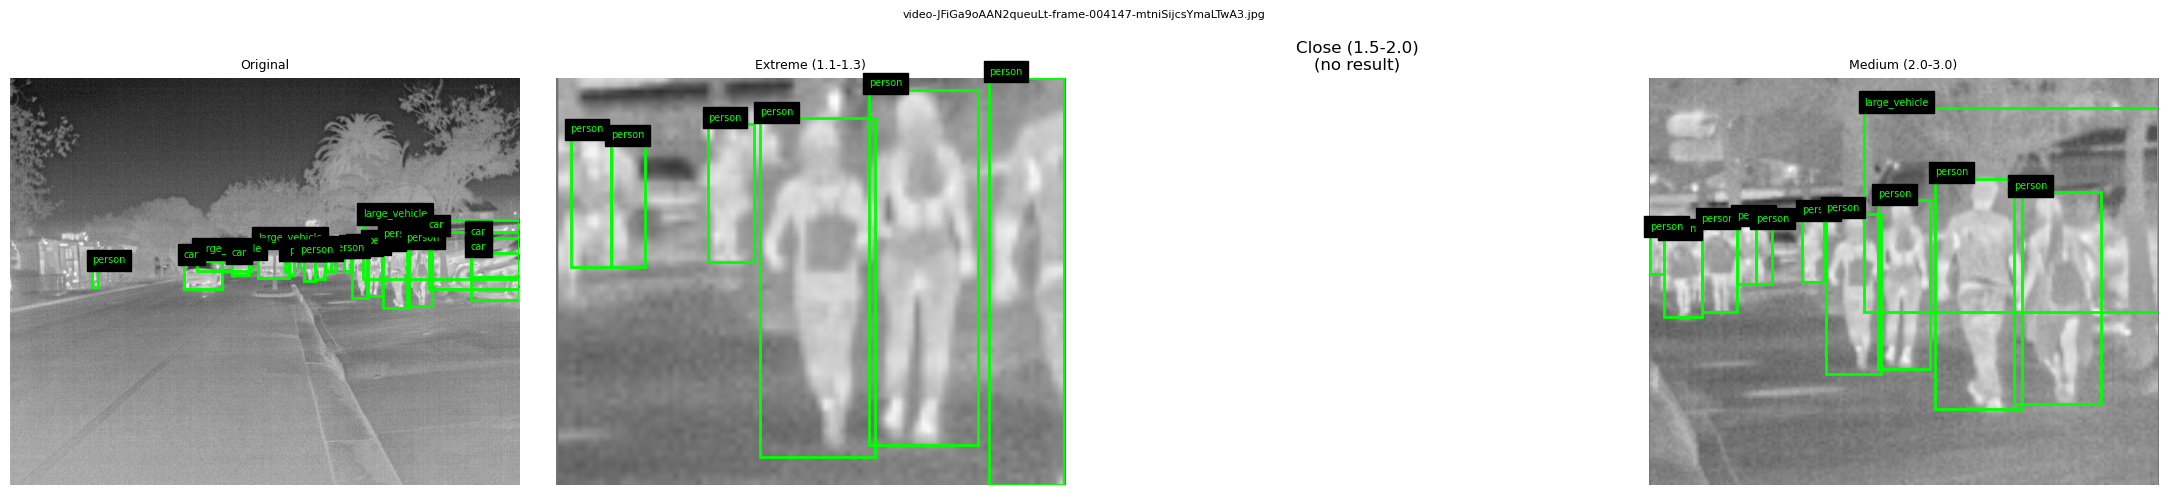

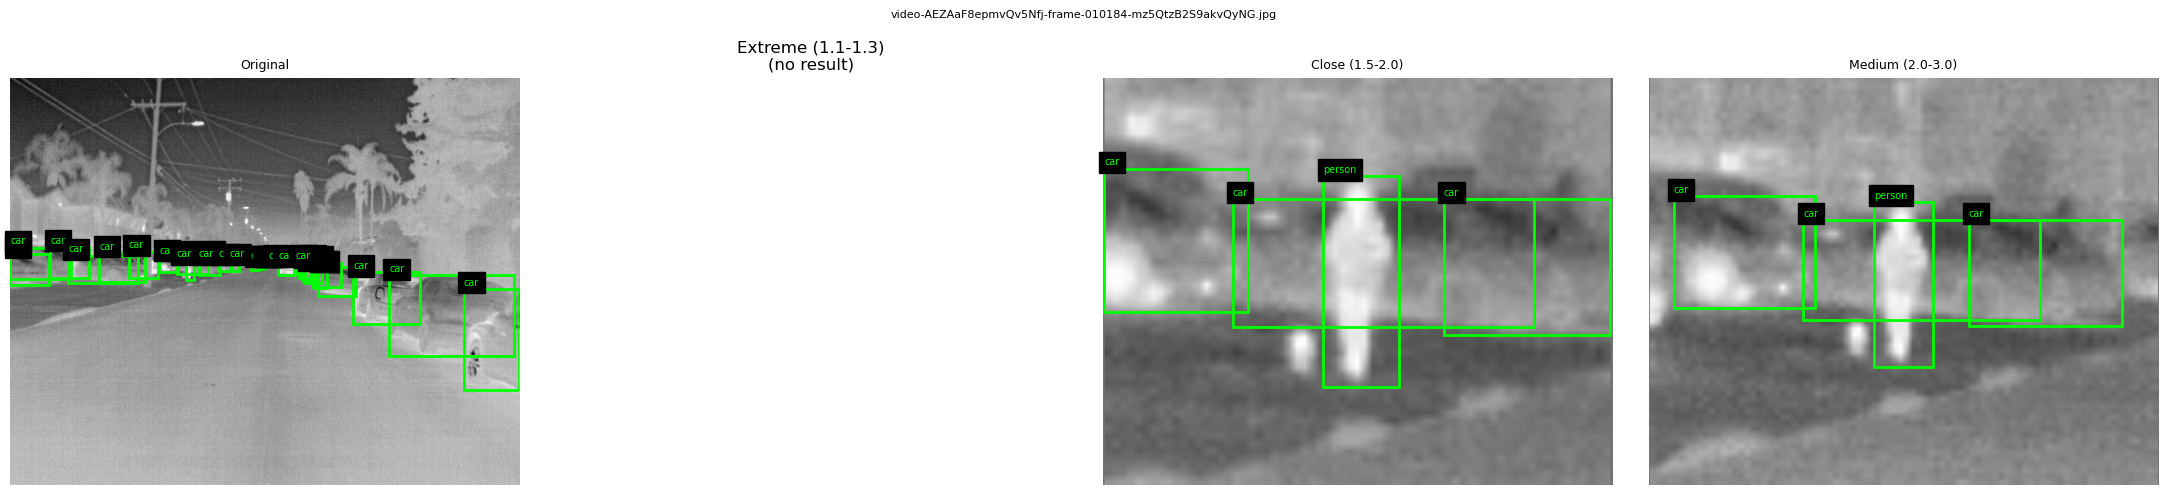

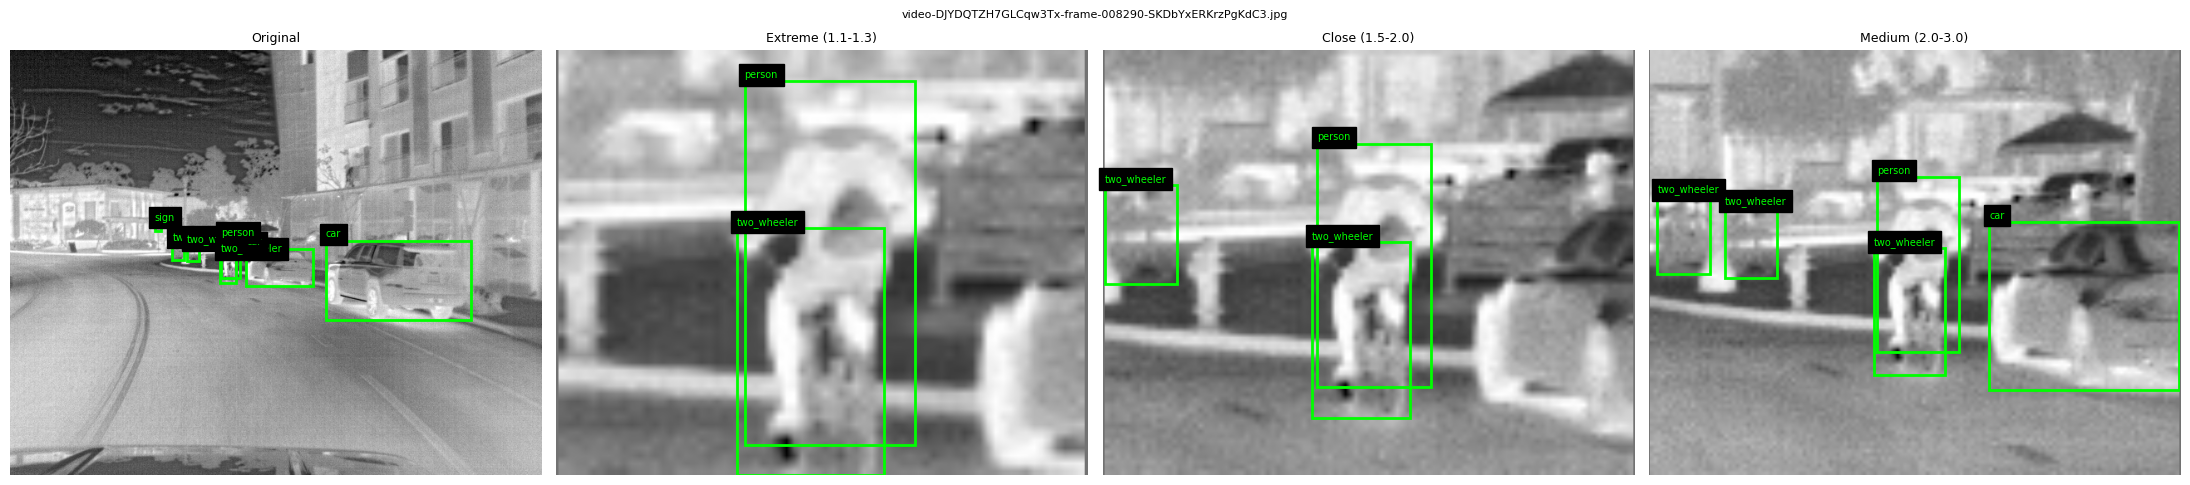

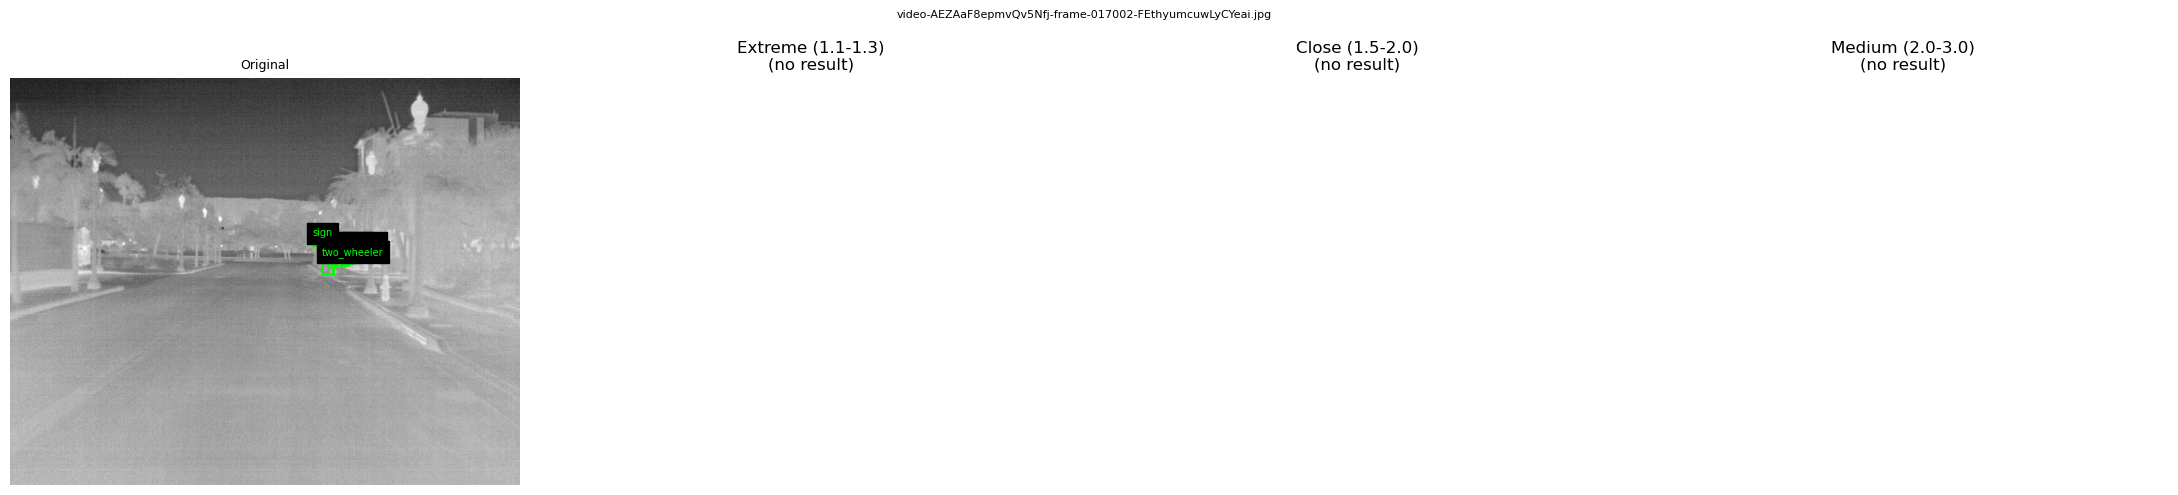

In [22]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_boxes_on_ax(ax, img_bgr, boxes, title, names):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w    = img_rgb.shape[:2]
    ax.imshow(img_rgb)
    for b in boxes:
        cls, cx, cy, bw, bh = b
        x1 = (cx - bw/2) * w
        y1 = (cy - bh/2) * h
        rect = patches.Rectangle((x1, y1), bw*w, bh*h,
                                   linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-4, names[int(cls)] if int(cls) < len(names) else str(cls),
                color='lime', fontsize=7, backgroundcolor='black')
    ax.set_title(title, fontsize=9)
    ax.axis('off')

# ── Pick a few random images that contain person class ──
img_paths = list(Path(IMG_DIR).glob("*.jpg"))

# Filter to only images that have person boxes
person_images = []
for p in img_paths:
    lbl = Path(LABEL_DIR) / (p.stem + ".txt")
    if not lbl.exists():
        continue
    labels = load_labels(str(lbl))
    if any(b[0] == 0 for b in labels):
        person_images.append(p)

print(f"Found {len(person_images)} images with person class")

# Test on 5 random images
test_samples = random.sample(person_images, min(5, len(person_images)))

for img_path in test_samples:
    label_path = Path(LABEL_DIR) / (img_path.stem + ".txt")
    img        = cv2.imread(str(img_path))
    labels     = [list(b) for b in load_labels(str(label_path))]

    # Test all zoom levels side by side
    fig, axes = plt.subplots(1, 4, figsize=(22, 5))
    fig.suptitle(img_path.name, fontsize=8)

    draw_boxes_on_ax(axes[0], img, labels, "Original", names)

    zoom_configs = [
        ((1.1, 1.3), "Extreme (1.1-1.3)"),
        ((1.5, 2.0), "Close (1.5-2.0)"),
        ((2.0, 3.0), "Medium (2.0-3.0)"),
    ]

    for i, (zrange, title) in enumerate(zoom_configs):
        aug_img, aug_boxes = zoom_person(img.copy(), labels, zoom_range=zrange)
        if aug_img is not None and aug_boxes:
            draw_boxes_on_ax(axes[i+1], aug_img, aug_boxes, title, names)
        else:
            axes[i+1].set_title(f"{title}\n(no result)")
            axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
# ~~~~~~~~~~ Check data size after augmentation ~~~~~~~~~~
print(f"Training data size after augmentation: {len(list(Path(OUT_LBL).glob('*.txt')))}")

Training data size after augmentation: 8727


In [ ]:
# ~~~~~~~~~~~ Load all labels from a folder ~~~~~~~~~~~~
# ~~~~~~~~~~~ Load and combine train + train_augmented ~~~~~~~~~~~~
def load_combined_labels(label_dirs):
    """Load labels from multiple directories and combine them"""
    all_boxes = []
    for label_dir in label_dirs:
        for txt in Path(label_dir).glob("*.txt"):
            with open(txt) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls = int(parts[0])
                        cx, cy, w, h = map(float, parts[1:])
                        all_boxes.append((cls, cx, cy, w, h))
    return all_boxes


# Combine both folders
combined_boxes = load_combined_labels([
    os.path.join(ROOT, "labels", "train"),
    os.path.join(ROOT, "labels", "train_augmented"),
    # ROOT + r"\labels\train",
    # ROOT + r"\labels\train_augmented",
])

class_count = Counter(b[0] for b in combined_boxes)

print(f"Total boxes (train + train_augmented): {len(combined_boxes)}\n")
print("Class counts (combined):")
for cls_id, count in sorted(class_count.items()):
    name = names[cls_id] if cls_id < len(names) else str(cls_id)
    pct  = count / len(combined_boxes) * 100
    print(f"  {cls_id:>2} {name:<20} {count:>6}  ({pct:.2f}%)")

Total boxes (train + train_augmented): 189997

Class counts (combined):
   0 person                50984  (26.83%)
   1 two_wheeler           18369  (9.67%)
   2 car                   73644  (38.76%)
   3 large_vehicle          9983  (5.25%)
   4 light                 16225  (8.54%)
   5 sign                  20792  (10.94%)


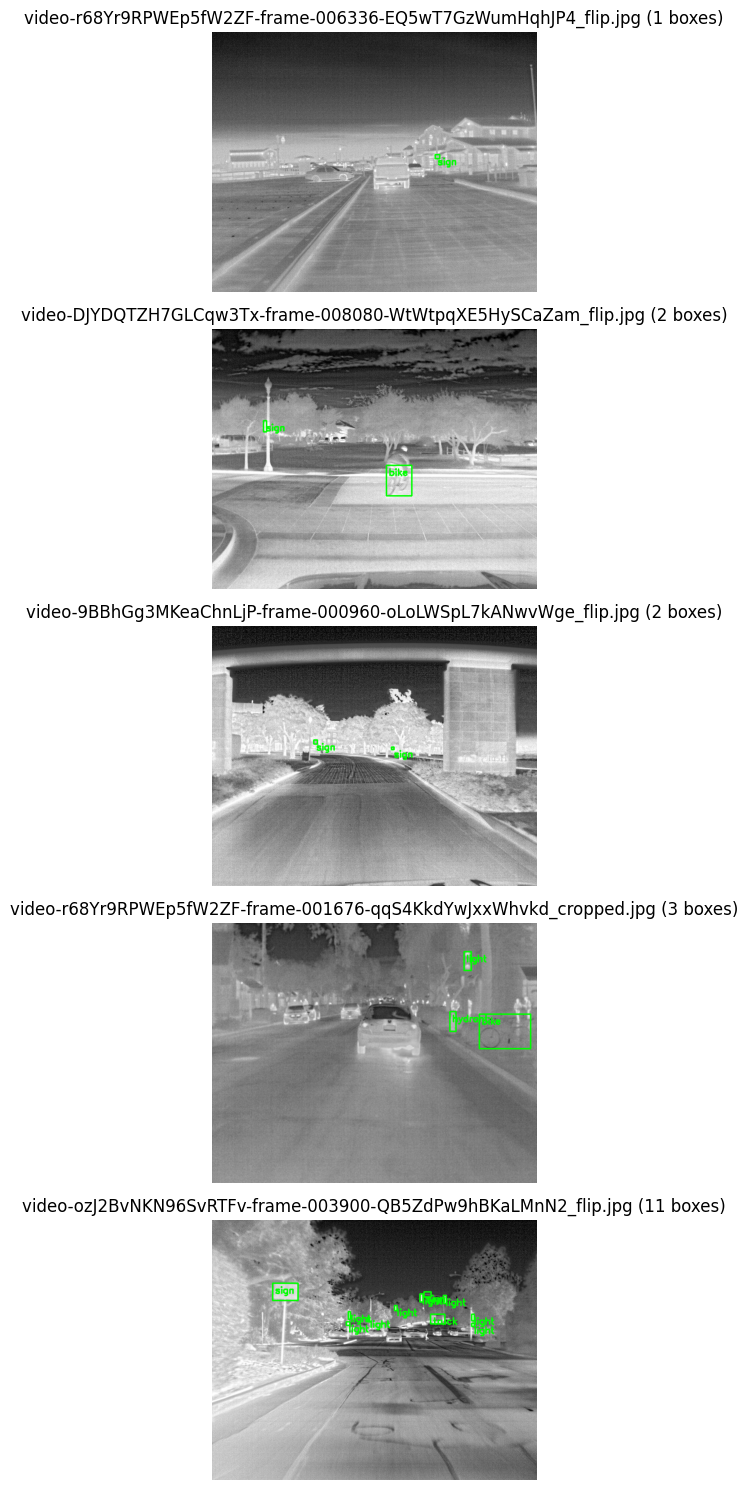

In [ ]:
# ~~~~~~~~~~~~ Display sample images with boxes ~~~~~~~~~~~~
def display_samples(label_dirs, num_samples=5):
    img_paths = []
    for label_dir in label_dirs:
        for txt in Path(label_dir).glob("*.txt"):
            img_path = Path(str(txt).replace("labels", "images").replace(".txt", ".jpg"))
            if img_path.exists():
                img_paths.append((img_path, txt))

    random.shuffle(img_paths)
    samples = img_paths[:num_samples]

    plt.figure(figsize=(15, 3 * num_samples))
    gs = gridspec.GridSpec(num_samples, 1)

    for i, (img_path, label_path) in enumerate(samples):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        with open(label_path) as f:
            boxes = []
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls = int(parts[0])
                    cx, cy, w, h = map(float, parts[1:])
                    boxes.append((cls, cx, cy, w, h))

        h, w = img.shape[:2]
        for cls, cx, cy, bw, bh in boxes:
            x1 = int((cx - bw/2) * w)
            y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w)
            y2 = int((cy + bh/2) * h)
            color = (255, 0, 0) if cls == 0 else (0, 255, 0)  # Red for person
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            label_name = names[cls] if cls < len(names) else str(cls)
            cv2.putText(img, label_name, (x1+5, y1+20), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, color, 2)

        ax = plt.subplot(gs[i])
        ax.imshow(img)
        ax.set_title(f"{img_path.name} ({len(boxes)} boxes)")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
display_samples([
    # ROOT + r"\labels\train_augmented",
    os.path.join(ROOT, "labels", "train_augmented")
])

Original labels:
  class=3 cx=0.1859 cy=0.4590 w=0.0906 h=0.0742
  class=4 cx=0.8844 cy=0.3477 w=0.0094 h=0.0391
  class=4 cx=0.8516 cy=0.3477 w=0.0125 h=0.0430
  class=4 cx=0.7586 cy=0.3633 w=0.0109 h=0.0391
  class=4 cx=0.7617 cy=0.4072 w=0.0172 h=0.0215
  class=4 cx=0.5422 cy=0.2617 w=0.0094 h=0.0391
  class=4 cx=0.3664 cy=0.2510 w=0.0109 h=0.0410
  class=4 cx=0.4242 cy=0.4121 w=0.0047 h=0.0117
  class=4 cx=0.4625 cy=0.4150 w=0.0031 h=0.0098
  class=4 cx=0.0172 cy=0.0322 w=0.0281 h=0.0645
  class=5 cx=0.6336 cy=0.3135 w=0.0672 h=0.0176
  class=5 cx=0.6430 cy=0.4111 w=0.0109 h=0.0137
  class=5 cx=0.6438 cy=0.4209 w=0.0063 h=0.0059
  class=5 cx=0.0508 cy=0.4307 w=0.0172 h=0.0332
  class=0 cx=0.5391 cy=0.4619 w=0.0094 h=0.0254
  class=0 cx=0.2578 cy=0.4824 w=0.0625 h=0.1250
  class=3 cx=0.4602 cy=0.4521 w=0.0109 h=0.0176
  class=2 cx=0.7922 cy=0.5186 w=0.2750 h=0.2168
  class=2 cx=0.3977 cy=0.4834 w=0.1922 h=0.0762
  class=2 cx=0.2687 cy=0.4766 w=0.0594 h=0.0430
  class=2 cx=0.9781 cy=

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


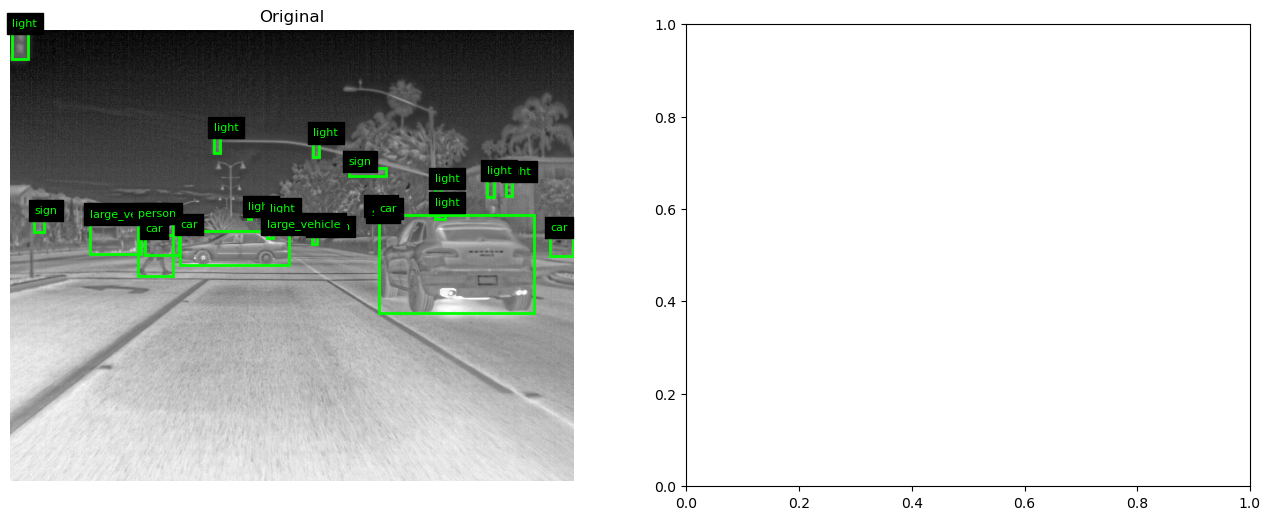

In [17]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import yaml
import os

def debug_augmentation(orig_img_path, aug_img_path, orig_lbl_path, aug_lbl_path, names):
    """Side by side comparison of original vs augmented with boxes drawn from raw label values"""

    def read_labels(path):
        boxes = []
        path = Path(path)
        if path.exists():
            with open(path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        boxes.append([int(parts[0])] + [float(x) for x in parts[1:]])
        return boxes

    def draw_on_ax(ax, img_bgr, boxes, title):
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]
        ax.imshow(img_rgb)
        for b in boxes:
            cls, cx, cy, bw, bh = b
            x1 = (cx - bw/2) * w
            y1 = (cy - bh/2) * h
            rect = patches.Rectangle((x1, y1), bw*w, bh*h,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 4,
                    names[cls] if cls < len(names) else str(cls),
                    color='lime', fontsize=8, backgroundcolor='black')
        ax.set_title(title)
        ax.axis('off')

    orig_img  = cv2.imread(orig_img_path)
    aug_img   = cv2.imread(aug_img_path)

    orig_boxes = read_labels(orig_lbl_path)
    aug_boxes  = read_labels(aug_lbl_path)

    print("Original labels:")
    for b in orig_boxes:
        print(f"  class={b[0]} cx={b[1]:.4f} cy={b[2]:.4f} w={b[3]:.4f} h={b[4]:.4f}")
    print("\nAugmented labels:")
    for b in aug_boxes:
        print(f"  class={b[0]} cx={b[1]:.4f} cy={b[2]:.4f} w={b[3]:.4f} h={b[4]:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    draw_on_ax(axes[0], orig_img, orig_boxes, "Original")
    draw_on_ax(axes[1], aug_img,  aug_boxes,  "Augmented")
    plt.tight_layout()
    plt.show()


# ---- Usage ----

stem     = "video-2MbnnGTv27EBLGqiQ-frame-000150-7sLLLYKqSjvsjXQhn"   # without extension
aug_type = "zoom_person"                 # crop / flip / crop_person

with open(os.path.join(ROOT, "config.yml")) as f:
    names = yaml.safe_load(f)["names"]

# ORIGINAL paths
orig_img_path = os.path.join(ROOT, "images", "train", f"{stem}.jpg")
orig_lbl_path = os.path.join(ROOT, "labels", "train", f"{stem}.txt")

# AUGMENTED paths
aug_img_path  = os.path.join(OUT_IMG, f"{stem}_{aug_type}.jpg")
aug_lbl_path  = os.path.join(OUT_LBL, f"{stem}_{aug_type}.txt")

debug_augmentation(
    orig_img_path,
    aug_img_path,
    orig_lbl_path,
    aug_lbl_path,
    names
)


crop_person files total       : 4525
  ✅ with person label (cls 0) : 41
  ❌ without person label      : 4484


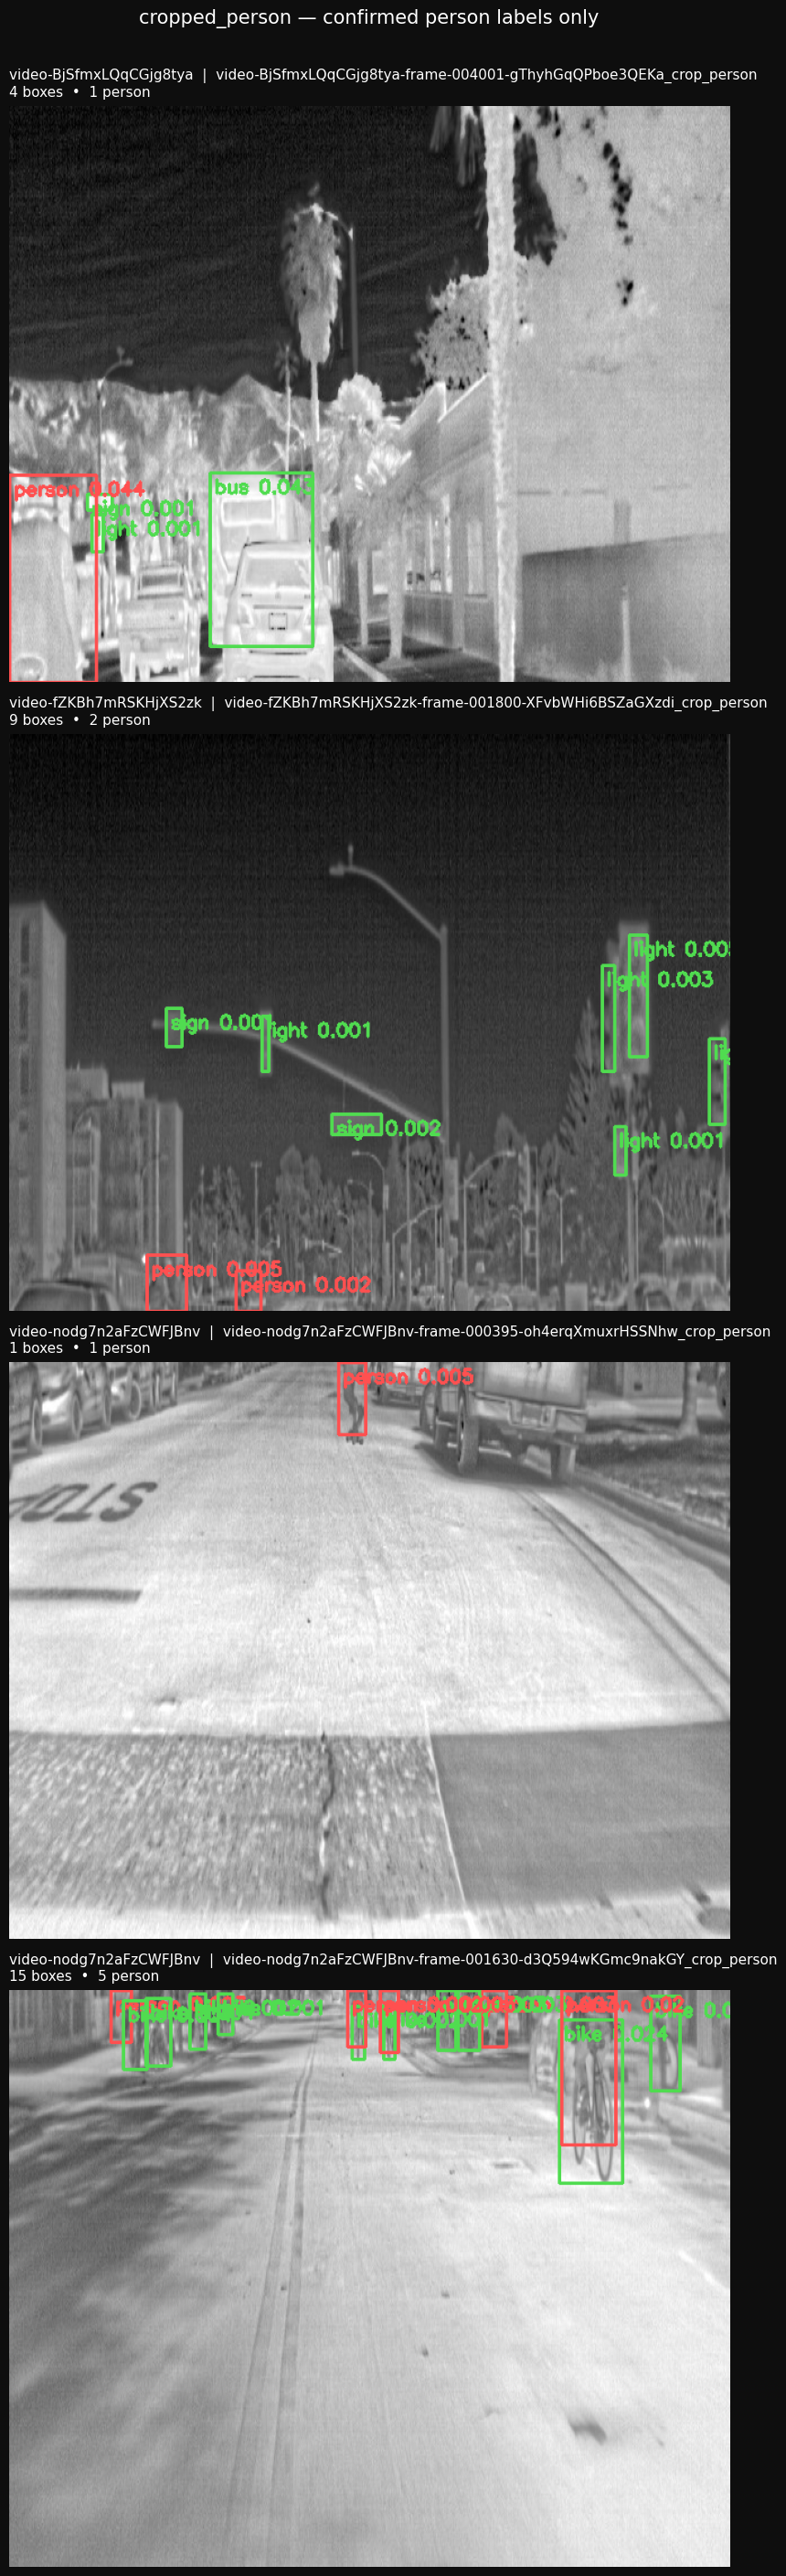


Showing 4 of 41 valid cropped_person samples


In [34]:
# ~~~~~~~~~~~~ Display 4 random cropped_person samples WITH real person labels ~~~~~~~~~~~~
def display_cropped_person_samples(label_dir, img_dir, num_samples=4):

    all_crop_person_files = list(Path(label_dir).glob("*_crop_person.txt"))

    if not all_crop_person_files:
        print("No cropped_person samples found.")
        return

    # ── Filter: only keep files that contain at least one person (class 0) box ──
    cropped_person_files = []
    for txt in all_crop_person_files:
        with open(txt) as f:
            has_person = any(
                line.strip().split()[0] == "0"
                for line in f
                if len(line.strip().split()) == 5
            )
        if has_person:
            cropped_person_files.append(txt)

    total_with_person  = len(cropped_person_files)
    total_without      = len(all_crop_person_files) - total_with_person

    print(f"crop_person files total       : {len(all_crop_person_files)}")
    print(f"  ✅ with person label (cls 0) : {total_with_person}")
    print(f"  ❌ without person label      : {total_without}")

    if not cropped_person_files:
        print("None of the crop_person files contain a person label.")
        return

    random.shuffle(cropped_person_files)
    samples = cropped_person_files[:num_samples]

    fig, axes = plt.subplots(num_samples, 1, figsize=(14, 7 * num_samples))
    fig.patch.set_facecolor("#0e0e0e")

    if num_samples == 1:
        axes = [axes]

    for ax, label_path in zip(axes, samples):
        img_path = Path(img_dir) / (label_path.stem + ".jpg")

        if not img_path.exists():
            ax.set_title("Image not found", color="white")
            ax.axis("off")
            continue

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        with open(label_path) as f:
            boxes = [line.strip().split() for line in f if len(line.strip().split()) == 5]

        person_count = 0
        for parts in boxes:
            cls            = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:])

            x1 = int((cx - bw/2) * w)
            y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w)
            y2 = int((cy + bh/2) * h)

            if cls == 0:
                color = (255, 80, 80)
                person_count += 1
            else:
                color = (80, 220, 80)

            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            label_name = names[cls] if cls < len(names) else str(cls)
            box_area   = round(bw * bh, 3)
            cv2.putText(img, f"{label_name} {box_area}", (x1+4, max(y1+18, 18)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)

        stem     = label_path.stem
        parts_fn = stem.split("-")
        try:
            video_id = parts_fn[1]
        except IndexError:
            video_id = stem

        ax.imshow(img)
        ax.set_title(
            f"video-{video_id}  |  {stem}\n"
            f"{len(boxes)} boxes  •  {person_count} person",
            color="white", fontsize=11, pad=8, loc="left"
        )
        ax.axis("off")

    plt.suptitle("cropped_person — confirmed person labels only", color="white",
                 fontsize=15, y=1.005)
    plt.tight_layout()
    plt.show()
    print(f"\nShowing {len(samples)} of {total_with_person} valid cropped_person samples")


# ── Run ───────────────────────────────────────────────────────────────────────
display_cropped_person_samples(
    label_dir = os.path.join(ROOT, "labels", "train_augmented"),
    img_dir   = os.path.join(ROOT, "images", "train_augmented"),
)